# Generalized Linear Models for Traffic Accident Counts
In this notebook, GLM to model the count of traffic crashes will be developed.

In [1]:
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, MultiPolygon
from shapely.wkt import loads
from toolbox import *
from scipy.stats import nbinom

warnings.filterwarnings("ignore")

## Read Dataset
The dataset is obtained from Chicago Data Potal.

In [2]:
# Read the data
df = pd.concat([pd.read_csv(f"Data/Traffic_Crashes_{i}.csv") for i in range(8)], ignore_index=True)

## Data Description
In the following, the basic information of the original dataset will be shown.

In [3]:
print(f"# of observations: {df.shape[0]}, # of features: {df.shape[1]}")

# of observations: 799526, # of features: 48


In [4]:
pd.set_option('display.max_columns', None)
df.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,DATE_POLICE_NOTIFIED,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...,NaN,08/18/2023 12:50:00 PM,15,OTHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,OTHER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,NaN,"OVER $1,500",08/18/2023 12:55:00 PM,FOLLOWING TOO CLOSELY,DISTRACTION - FROM INSIDE VEHICLE,700,W,OHARE ST,1654.0,NaN,NaN,NaN,NaN,NaN,NaN,2,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,1.0,0.0,12,6,8,NaN,NaN,NaN
1,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,NaN,07/29/2023 02:45:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,Y,"OVER $1,500",07/29/2023 02:45:00 PM,FAILING TO REDUCE SPEED TO AVOID CRASH,"OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",2101,S,ASHLAND AVE,1235.0,NaN,NaN,NaN,NaN,NaN,NaN,4,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,14,7,7,41.854120,-87.665902,POINT (-87.665902342962 41.854120262952)
2,61fcb8c1eb522a6469b460e2134df3d15f82e81fd93e9c...,NaN,08/18/2023 05:58:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,NaN,"$501 - $1,500",08/18/2023 06:01:00 PM,FAILING TO REDUCE SPEED TO AVOID CRASH,UNABLE TO DETERMINE,3422,N,LONG AVE,1633.0,NaN,NaN,NaN,NaN,NaN,NaN,2,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,1.0,0.0,17,6,8,41.942976,-87.761883,POINT (-87.761883496974 41.942975745006)
3,004cd14d0303a9163aad69a2d7f341b7da2a8572b2ab33...,NaN,11/26/2019 08:38:00 AM,25,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDESTRIAN,ONE-WAY,NaN,CURVE ON GRADE,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,NaN,"OVER $1,500",11/26/2019 08:38:00 AM,UNABLE TO DETERMINE,NOT APPLICABLE,5,W,TERMINAL ST,1655.0,Y,Y,NaN,NaN,NaN,NaN,2,FATAL,1.0,1.0,0.0,0.0,0.0,1.0,0.0,8,3,11,NaN,NaN,NaN
4,a1d5f0ea90897745365a4cbb06cc60329a120d89753fac...,NaN,08/18/2023 10:45:00 AM,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,OTHER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",08/18/2023 10:48:00 AM,FOLLOWING TOO CLOSELY,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,3,W,TERMINAL ST,1653.0,NaN,NaN,NaN,NaN,NaN,NaN,1,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10,6,8,NaN,NaN,NaN


In [5]:
df.describe()

,POSTED_SPEED_LIMIT,LANE_CNT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,799526.000000,1.990060e+05,799526.000000,799521.000000,799526.000000,797771.000000,797771.000000,797771.000000,797771.000000,797771.000000,797771.000000,797771.0,799526.000000,799526.000000,799526.000000,794081.000000,794081.000000
mean,28.403780,1.333032e+01,3688.695708,1243.135123,2.034823,0.189443,0.001187,0.019997,0.106981,0.061278,2.004076,0.0,13.201700,4.123786,6.756523,41.854820,-87.673497
std,6.177193,2.961623e+03,2888.049772,705.252405,0.452526,0.565504,0.037333,0.165503,0.421910,0.318553,1.158045,0.0,5.568989,1.980238,3.423399,0.336628,0.684215
min,0.000000,0.000000e+00,0.000000,111.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,-87.936193
25%,30.000000,2.000000e+00,1249.000000,714.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,9.000000,2.000000,4.000000,41.782440,-87.721733
50%,30.000000,2.000000e+00,3201.000000,1211.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,14.000000,4.000000,7.000000,41.874778,-87.674114
75%,30.000000,4.000000e+00,5600.000000,1822.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,17.000000,6.000000,10.000000,41.924350,-87.633304
max,99.000000,1.191625e+06,451100.000000,6100.000000,18.000000,21.000000,4.000000,10.000000,21.000000,15.000000,61.000000,0.0,23.000000,7.000000,12.000000,42.022780,0.000000


## Preprocessing

### Reducing demension
* To create GLM, we need to create a count data from the original data.
* Creating the count data lead to aggregating the original data.
* We will drop features which cannot be aggregated in advance.

In [6]:
df = df[["CRASH_DATE", "INJURIES_TOTAL", "INJURIES_FATAL", "CRASH_DAY_OF_WEEK", "LATITUDE", "LONGITUDE"]]

### Handling date time variables
* Deviding the variable "**CRASH_DATE**" into separete date time variables: "**CRASH_DATE_year**", "**CRASH_DATE_month**", "**CRASH_DATE_day**", "**CRASH_DATE_hour**", "**CRASH_DATE_minute**", "**CRASH_DATE_second**"

In [7]:
df = datetime_transformer(df, ["CRASH_DATE"])

### Removing obsevations prior to September 2017
* The observations are collected from 2015, but the observations from 2015 to August 2017 are collected from a part of the city.

In [8]:
df.drop(index=df[(df.CRASH_DATE_year<2016)].index, inplace=True)
df.drop(index=df[(df.CRASH_DATE_year==2017) & (df.CRASH_DATE_month<=8)].index, inplace=True)

### Handling missing value
* Removing observations with any missing values.

In [9]:
# show features with missing values and its counts and percentage
miss_num = df.isna().sum()[df.isna().sum() > 0]
miss_ratio = miss_num * 100 / df.shape[0]
df_miss = pd.DataFrame(data=[miss_num, miss_ratio], index=["# of missing value", "Percentage of missing value"]).T
df_miss

,# of missing value,Percentage of missing value
INJURIES_TOTAL,1674.0,0.224823
INJURIES_FATAL,1674.0,0.224823
LATITUDE,5216.0,0.700524
LONGITUDE,5216.0,0.700524


In [10]:
# drop rows with missing value
df.dropna(axis=0, inplace=True)

### Removing constant features
* Removing constant features, which means features with only one value.

In [11]:
# remove constant features
const_features = df.nunique()[df.nunique()==1].index
df.drop(columns=const_features, inplace=True)

### Removing unreliable observations
* There are some unreliable values in "CRASH_DATE_year", "LONGITUDE", and "LATITUDE".
* The observations containing unrealiable values will be removed.

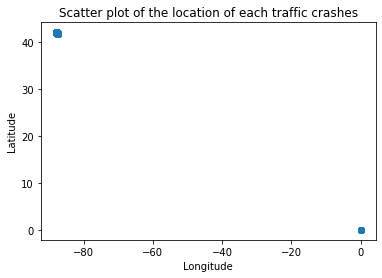

In [12]:
plt.scatter(df.LONGITUDE, df.LATITUDE)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Scatter plot of the location of each traffic crashes")
plt.show()

Chicago is a city in the U.S., so the data in the bottom right in the above graph have errors in their location information.

In [13]:
df.drop(index=df[df.LATITUDE < 10].index, inplace=True)

### Feature Engineering
* Creating the target variable "**Severity**" from "**INJURIES_TOTAL**" and "**INJURIES_FATAL**".  
* "Severity" has three levels:  
    * 3: "INJURIES_TOTAL" $>=3$ or "INJURIES_FATAL" $>= 1$  
    * 2: $1<=$ "INJURIES_TOTAL" $<=2$  
    * 1: "INJURIES_TOTAL" $=0$

In [14]:
df = create_severity(df)

* Creating a new feature, which value is community area name in the city of Chicago

In [15]:
# read community area data
df_comm = pd.read_csv("Data/CommAreas.csv")

# convert the data type of 'the_geom' into the appropriate type: Multipolygon 
df_comm['the_geom'] = df_comm['the_geom'].apply(loads)

# Create Point object
geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

series_comm = pd.Series([np.nan]*gdf.shape[0], index=gdf.index)
gdf_geom = gdf.geometry
df_comm_geom = gpd.GeoSeries(df_comm.the_geom)
for i in range(gdf.shape[0]):
    temp = df_comm_geom.contains(gdf_geom.iloc[i])
    if np.any(temp):
        series_comm.iloc[i] = df_comm.COMMUNITY[temp[temp==True].index[0]]
        
df["Community_area"] = series_comm

### Removing observations outside of Chicago city
* Removing observations in which the traffic crashes occured outside of Chicago city

In [16]:
# show the number of observations outside of Chicago city
df.Community_area.isna().sum()

329

In [17]:
# remove observations outside of Chicago city
df.dropna(axis=0, inplace=True)

In [18]:
df.head()

,INJURIES_TOTAL,INJURIES_FATAL,CRASH_DAY_OF_WEEK,LATITUDE,LONGITUDE,CRASH_DATE_year,CRASH_DATE_month,CRASH_DATE_day,CRASH_DATE_hour,CRASH_DATE_minute,Severity,Community_area
1,0.0,0.0,7,41.854120,-87.665902,2023,7,29,14,45,1,LOWER WEST SIDE
2,1.0,0.0,6,41.942976,-87.761883,2023,8,18,17,58,2,PORTAGE PARK
13,0.0,0.0,7,41.809781,-87.594213,2023,7,29,14,30,1,KENWOOD
14,0.0,0.0,7,41.899225,-87.696642,2023,7,29,0,50,1,WEST TOWN
20,0.0,0.0,4,41.744152,-87.585945,2023,9,20,12,57,1,AVALON PARK


### Creating a new data frame
* creating a new data frame used for developing GLM
* The new data frame contains "Year", "Month", "Day", "Time_frame", "Day_of_week", "Severity", "Community_area", and "Count" as its features

In [19]:
df_agg = create_count_df(create_initial_df(df, 2017, 9, 1, 2024, 1, 22), df)

In [20]:
df_agg.head()

,Year,Month,Day,Time_frame,Day_of_week,Severity,Community_area,Count
0,2017,9,1,0-2,6,1,LOWER WEST SIDE,0
1,2017,9,1,2-4,6,1,LOWER WEST SIDE,0
2,2017,9,1,4-6,6,1,LOWER WEST SIDE,0
3,2017,9,1,6-8,6,1,LOWER WEST SIDE,0
4,2017,9,1,8-10,6,1,LOWER WEST SIDE,0


## EDA

### Histogram of the number of traffic accidents per two hours
* There are several peaks, which means this sample is a mixture of different groups.

In [21]:
whole_city = df_agg[["Year", "Month", "Day", "Time_frame", "Count"]].groupby(["Year", "Month", "Day", "Time_frame"]).sum()

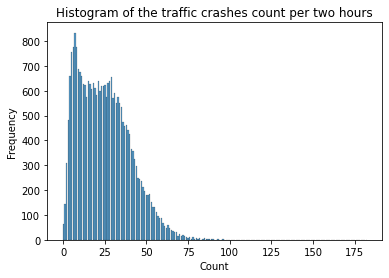

In [48]:
sns.histplot(whole_city.Count, discrete=True, shrink=0.8)
plt.title("Histogram of the traffic crashes count per two hours")
plt.ylabel("Frequency")
plt.show()

### Number of traffic accidents in each community area
* "Austin" has the most traffic crashes, and "BURNSIDE" has the least.

In [23]:
pd.set_option('display.max_rows', None)

df_count = df_agg[["Community_area", "Count"]].groupby(["Community_area"]).sum().sort_values("Count", ascending=False)
df_count["percentage"] = df_count["Count"] * 100 / sum(df_count["Count"])
df_count["cum_percentage"] = [0] * df_count.shape[0]
df_count["rank"] = [0] * df_count.shape[0]
for i in range(df_count.shape[0]):
    df_count["cum_percentage"].iloc[i] = sum(df_count["percentage"].iloc[: i +1])
    df_count["rank"].iloc[i] = i + 1
df_count

,Count,percentage,cum_percentage,rank
Community_area,,,,
AUSTIN,33348,4.809907,4.809907,1
NEAR WEST SIDE,32063,4.624567,9.434474,2
NEAR NORTH SIDE,31299,4.514372,13.948846,3
LOOP,22633,3.264442,17.213289,4
WEST TOWN,20246,2.920157,20.133445,5
BELMONT CRAGIN,17723,2.556255,22.689700,6
LOGAN SQUARE,15945,2.299807,24.989507,7
HUMBOLDT PARK,15612,2.251777,27.241284,8
LAKE VIEW,15490,2.234181,29.475465,9


### Histogram of the number of traffic accidents per two hours and Community Area
* The distribution of the traffic crashes count looks different by community area

In [24]:
by_comm = df_agg[["Year", "Month", "Day", "Time_frame", "Community_area", "Count"]].groupby(["Year", "Month", "Day", "Time_frame", "Community_area"]).sum().reset_index(level='Community_area')

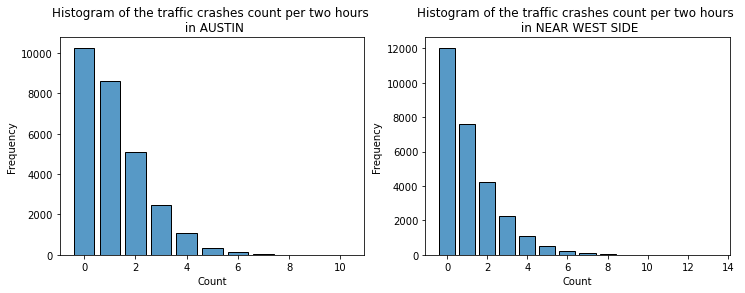

In [49]:
fig, axes = plt.subplots(1,2, figsize=(12, 4))
sns.histplot(by_comm[by_comm.Community_area=="AUSTIN"].Count, discrete=True, shrink=0.8, ax=axes[0])
axes[0].set_title("Histogram of the traffic crashes count per two hours \n in AUSTIN")
axes[0].set_ylabel("Frequency")
sns.histplot(by_comm[by_comm.Community_area=="NEAR WEST SIDE"].Count, discrete=True, shrink=0.8, ax=axes[1])
axes[1].set_title("Histogram of the traffic crashes count per two hours \n in NEAR WEST SIDE")
axes[1].set_ylabel("Frequency")
plt.show()

### Number of traffic accidents per 2 hours for each Severity in Austin
* The distribution appears to be different for each severity

In [26]:
Austin = df_agg[df_agg.Community_area=="AUSTIN"]
Austin_severity = Austin[["Year", "Month", "Day", "Time_frame", "Severity", "Count"]].groupby(
    ["Year", "Month", "Day", "Time_frame", "Severity"]).sum().reset_index(level="Severity")

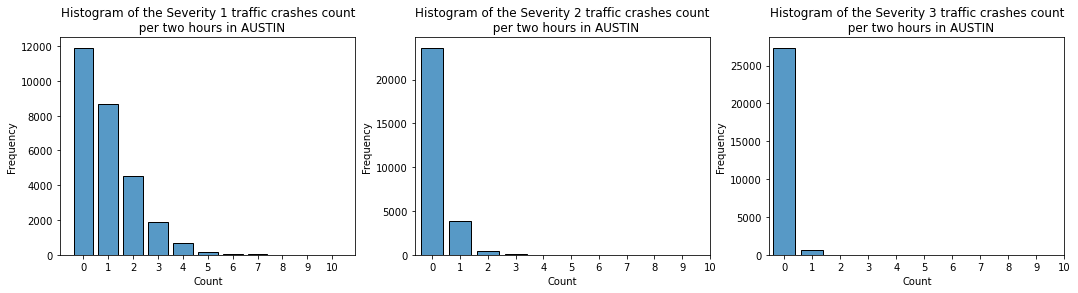

In [50]:
fig, axes = plt.subplots(1,3, figsize=(18, 4))
sns.histplot(Austin_severity[(Austin_severity.Severity==1)].Count, discrete=True, shrink=0.8, ax=axes[0])
sns.histplot(Austin_severity[(Austin_severity.Severity==2)].Count, discrete=True, shrink=0.8, ax=axes[1])
sns.histplot(Austin_severity[(Austin_severity.Severity==3)].Count, discrete=True, shrink=0.8, ax=axes[2])
axes[0].set_title("Histogram of the Severity 1 traffic crashes count\n  per two hours in AUSTIN")
axes[0].set_xticks(range(11))
axes[0].set_ylabel("Frequency")
axes[1].set_title("Histogram of the Severity 2 traffic crashes count\n  per two hours in AUSTIN")
axes[1].set_xticks(range(11))
axes[1].set_ylabel("Frequency")
axes[2].set_title("Histogram of the Severity 3 traffic crashes count\n  per two hours in AUSTIN")
axes[2].set_xticks(range(11))
axes[2].set_ylabel("Frequency")
plt.show()

### Number of traffic accidents per 2 hours for each day of the week in Austin
* The distribution appears to be different for each day of the week. Especially, the traffic crashes tend to more happen on Sundays.

In [28]:
Austin_dof = Austin[["Year", "Month", "Day", "Time_frame", "Day_of_week", "Count"]].groupby(
    ["Year", "Month", "Day", "Time_frame", "Day_of_week"]).sum().reset_index(level="Day_of_week")

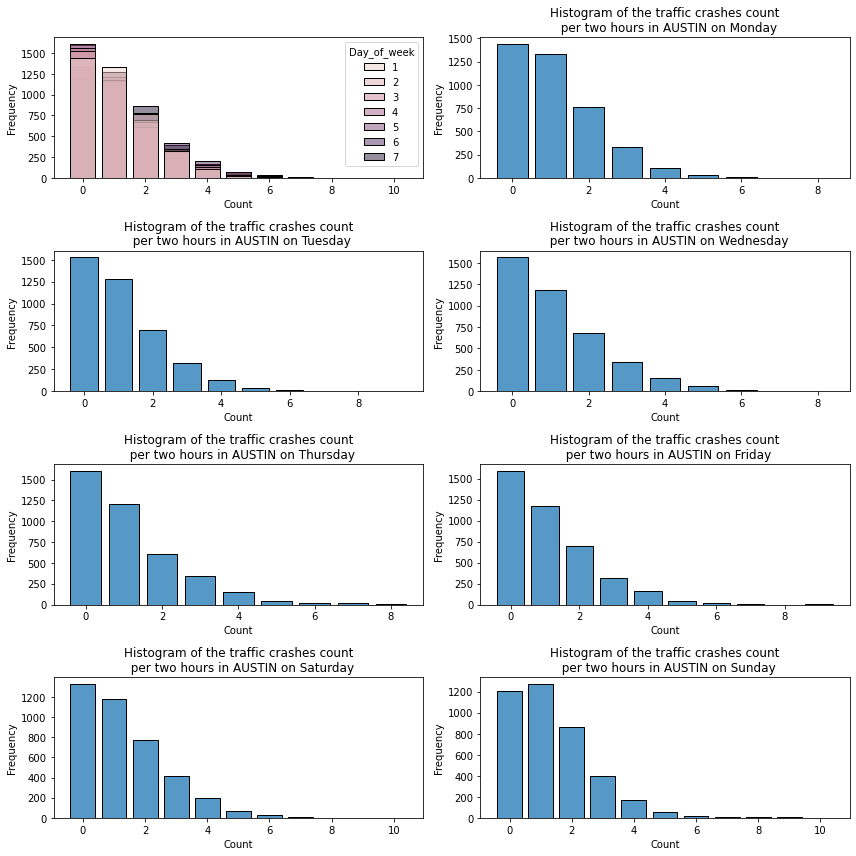

In [51]:
dof_dict = {1:"Monday", 2:"Tuesday", 3:"Wednesday", 4:"Thursday", 5:"Friday", 6: "Saturday", 7:"Sunday"}
fig, axes = plt.subplots(4,2, figsize=(12, 12))
sns.histplot(data=Austin_dof, x="Count", hue="Day_of_week", discrete=True, shrink=0.8, ax=axes[0][0])
axes[0][0].set_ylabel("Frequency")
for dof in range(1, 8):
    i = dof // 2
    j = dof % 2
    sns.histplot(data=Austin_dof[Austin_dof.Day_of_week==dof], x="Count", discrete=True, shrink=0.8, ax=axes[i][j])
    axes[i][j].set_title(f"Histogram of the traffic crashes count\n  per two hours in AUSTIN on {dof_dict[dof]}")
    axes[i][j].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

### Number of traffic accidents per 2 hours for each month in Austin
* The distribution appears to be different for each month

In [30]:
Austin_month = Austin[["Year", "Month", "Day", "Time_frame", "Count"]].groupby(
    ["Year", "Month", "Day", "Time_frame"]).sum()
Austin_month["Month"] = Austin_month.index.get_level_values('Month')

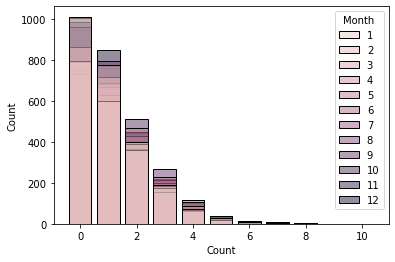

In [31]:
sns.histplot(data=Austin_month, x="Count", hue="Month", discrete=True, shrink=0.8)
plt.ylabel("Frequency")
plt.show()

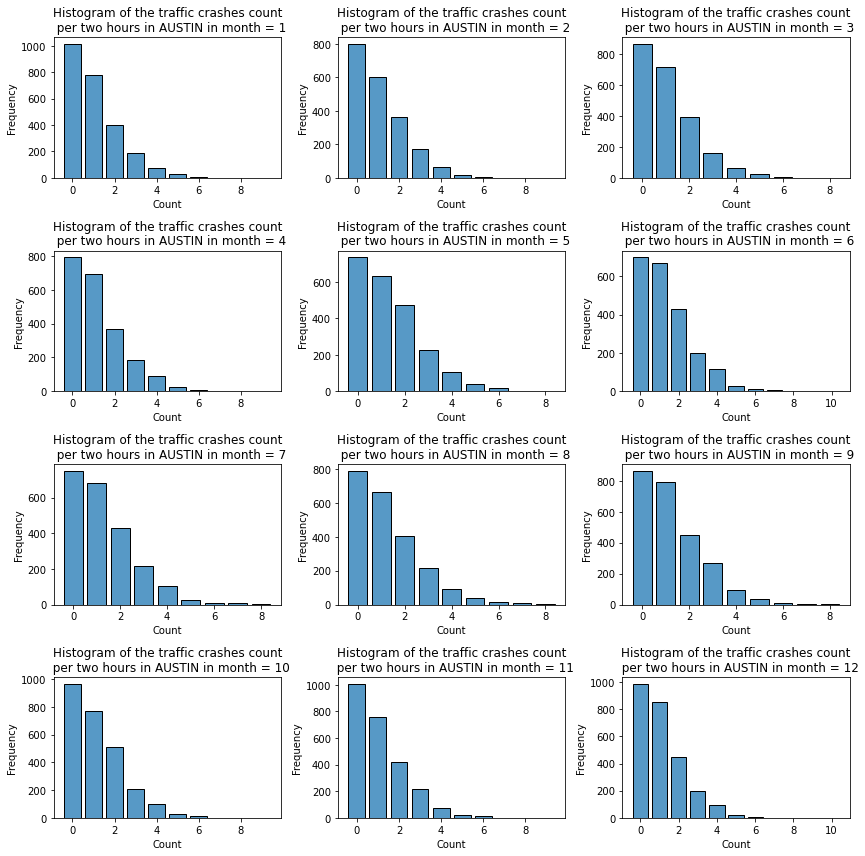

In [52]:
fig, axes = plt.subplots(4,3, figsize=(12, 12))
for m in range(12):
    i = m // 3
    j = m % 3
    sns.histplot(data=Austin_month[Austin_month.Month==m+1], x="Count", discrete=True, shrink=0.8, ax=axes[i][j])
    axes[i][j].set_title(f"Histogram of the traffic crashes count\n  per two hours in AUSTIN in month = {m+1}")
    axes[i][j].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

In [33]:
Austin_time = Austin[["Year", "Month", "Day", "Time_frame", "Count"]].groupby(
    ["Year", "Month", "Day", "Time_frame"]).sum()
Austin_time["Time_frame"] = Austin_time.index.get_level_values('Time_frame')

### Number of traffic accidents per 2 hours for each time frame in Austin
* The distribution appears to be different for each time frame. 

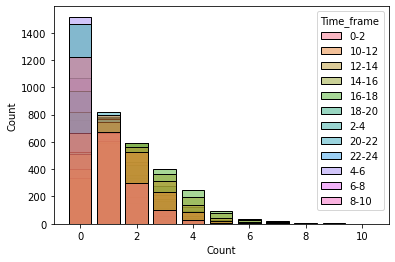

In [34]:
sns.histplot(data=Austin_time, x="Count", hue="Time_frame", discrete=True, shrink=0.8)
plt.ylabel("Frequency")
plt.show()

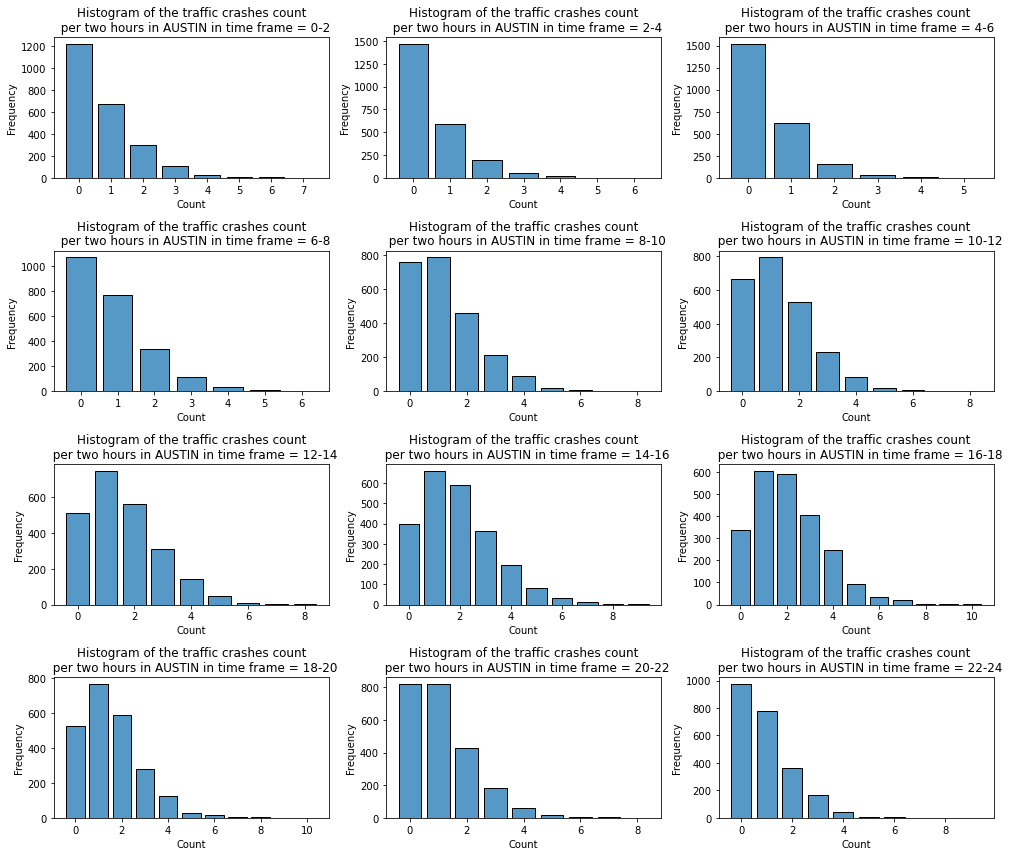

In [53]:
time_frame = ["0-2", "2-4", "4-6", "6-8", "8-10", "10-12", "12-14", "14-16", "16-18", "18-20", "20-22", "22-24"]
fig, axes = plt.subplots(4,3, figsize=(14, 12))
for t in range(12):
    i = t // 3
    j = t % 3
    sns.histplot(data=Austin_time[Austin_time.Time_frame==time_frame[t]], x="Count", discrete=True, shrink=0.8, ax=axes[i][j])
    axes[i][j].set_title(f"Histogram of the traffic crashes count\n  per two hours in AUSTIN in time frame = {time_frame[t]}")
    axes[i][j].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

## Model Development

### Further preprocessing
* Encoding the categorical features

In [36]:
top5 = df_count.iloc[:5].index
df_train = df_agg.drop(columns=["Year", "Day"])
df_train = df_train[df_train['Community_area'].isin(top5)]
df_train = df_train.astype({"Month": object, "Day_of_week": object, "Severity": object})
df_train = pd.get_dummies(df_train, drop_first=True)

In [37]:
df_train.head()

,Count,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Time_frame_10-12,Time_frame_12-14,Time_frame_14-16,Time_frame_16-18,Time_frame_18-20,Time_frame_2-4,Time_frame_20-22,Time_frame_22-24,Time_frame_4-6,Time_frame_6-8,Time_frame_8-10,Day_of_week_2,Day_of_week_3,Day_of_week_4,Day_of_week_5,Day_of_week_6,Day_of_week_7,Severity_2,Severity_3,Community_area_LOOP,Community_area_NEAR NORTH SIDE,Community_area_NEAR WEST SIDE,Community_area_WEST TOWN
252180,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
252181,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
252182,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
252183,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
252184,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1


### Poisson Model
We created eight different Poisson models, each with different sets of independent variables. Specifically, we constructed models with variations in whether they included "Month," "Time_Frame," and "Day_of_week" as independent variables. As a result, the model that included all of these variables as independent variables was found to be the best model based on AIC and BIC criteria.

In [38]:
import statsmodels.api as sm

y, X_full = df_train.Count, df_train.drop(columns=["Count"])
X_full = sm.add_constant(X_full)

In [39]:
from statsmodels.discrete.count_model import ZeroInflatedPoisson

def construct_GLM(X, y, family, drop_features_list=[]):
    X_temp = X.copy(deep=True)
    if len(drop_features_list) != 0:
        columns_to_drop = [col for string in drop_features_list for col in X_temp.columns if col.startswith(string)]
        X_temp = X_temp.drop(columns=columns_to_drop)
    if family == "ZeroInflated":
        model = ZeroInflatedPoisson(y, X_temp)
        model_results = model.fit(maxiter=100)
    else:
        model = sm.GLM(y, X_temp, family=family)
        model_results = model.fit()
    return model_results

In [40]:
drop_features_lists = [[], ["Month"], ["Time"], ["Day"], ["Time", "Day"], ["Month", "Day"], ["Month", "Time"], ["Month", "Time", "Day"]]
variables = ["Month + Time Frame + DOF", "Time Frame + DOF", "Month + DOF", "Month + Time Frame", "Month", "Time Frame", "DOF", "-"]
df_poisson = pd.DataFrame(index=variables)
aics = []
bics = []
for drop_features_list in drop_features_lists:
    model_temp = construct_GLM(X_full, y, sm.families.Poisson(), drop_features_list)
    aics.append(model_temp.aic)
    bics.append(model_temp.bic_llf)
df_poisson["AIC"] = aics
df_poisson["BIC"] = bics
df_poisson

,AIC,BIC
Month + Time Frame + DOF,459117.350196,459500.555536
Time Frame + DOF,459799.575019,460062.344396
Month + DOF,493646.275443,493909.044820
Month + Time Frame,460469.835955,460787.348951
Month,494998.761202,495195.838235
Time Frame,461153.030052,461350.107084
DOF,494328.500267,494470.833679
-,495681.955299,495758.596367


## Negative Binomial Model
We created eight different models with varying alpha values, which determine the difference between the mean and the variance. Each model had a different combination of independent variables. Specifically, we constructed models with variations in whether they included "Month," "Time_Frame," and "Day_of_week" as independent variables. Consequently, the model that included all these variables as independent variables was deemed the best model based on AIC and BIC criteria.

### AICs for models

In [41]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
df_negbin = pd.DataFrame(index=variables)
for alpha in alphas:
    aics = []
    for drop_features_list in drop_features_lists:
        aics.append(construct_GLM(X_full, y, sm.families.NegativeBinomial(alpha=alpha), drop_features_list).aic)
    df_negbin["alpha="+str(alpha)] = aics
df_negbin

,alpha=0.1,alpha=0.2,alpha=0.3,alpha=0.4,alpha=0.5,alpha=0.6,alpha=0.7,alpha=0.8,alpha=0.9,alpha=1,alpha=1.1,alpha=1.2,alpha=1.3,alpha=1.4,alpha=1.5,alpha=1.6,alpha=1.7,alpha=1.8,alpha=1.9,alpha=2
Month + Time Frame + DOF,457046.578966,456323.287119,456406.257155,457015.592392,457986.367924,459213.473167,460626.226599,462175.193912,463824.746783,465548.593057,467326.958787,469144.741236,470990.258916,472854.382653,474729.917563,476611.154743,478493.540438,480373.428210,482247.890771,484114.575431
Time Frame + DOF,457687.572618,456930.626457,456985.341325,457570.444574,458520.089529,459728.519913,461124.585628,462658.502398,464294.374191,466005.699886,467772.539567,469579.656678,471415.260407,473270.131212,475136.998734,477010.090443,478884.798491,480757.430100,482625.018010,484485.174826
Month + DOF,489125.056508,486330.838613,484633.958856,483692.875310,483298.040034,483311.062066,483635.828218,484203.072553,484961.433910,485871.952830,486904.523819,488035.521363,489246.161977,490521.344716,491848.812251,493218.532331,494622.234164,496053.055852,497505.272792,498974.086040
Month + Time Frame,458228.564157,457373.388815,457351.333022,457875.110895,458774.898859,459942.202322,461303.924176,462808.858876,464420.049792,466110.189360,467858.714434,469649.899932,471471.567256,473314.185585,475170.232154,477033.727897,478899.894554,480764.897669,482625.651370,484479.668320
Month,490377.015209,487496.941093,485725.780391,484719.726655,484267.533276,484229.507747,484508.521307,485034.502977,485755.444554,486631.860131,487633.211201,488735.512593,489919.679457,491170.356302,492475.069230,493823.600502,495207.519486,496619.825763,498054.674062,499507.159807
Time Frame,458869.633057,457980.153229,457929.380758,458428.605010,459307.043409,460455.528328,461800.474172,463290.310891,464887.803477,466565.427505,468302.447984,470083.001608,471894.797136,473728.210863,475575.642642,477431.048323,479289.594446,481147.399370,483001.336606,484848.883629
DOF,489773.524173,486950.043930,485227.491725,484263.654151,483848.473349,483843.163472,484151.300335,484703.369453,485447.808452,486345.493102,487366.181596,488486.134603,489686.472809,490952.013970,492270.431301,493631.632834,495027.296130,496450.514376,497895.523712,499357.490718
-,491025.281175,488115.055504,486317.539407,485288.202626,484815.251502,484758.571750,485020.703770,485531.313160,486238.179191,487101.642475,488091.021399,489182.211638,490356.028268,491597.031103,492892.674052,494232.677434,495608.557152,497013.266381,498440.919360,499886.576019


In [42]:
alphas = [0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]
df_negbin = pd.DataFrame(index=variables)
for alpha in alphas:
    aics = []
    for drop_features_list in drop_features_lists:
        aics.append(construct_GLM(X_full, y, sm.families.NegativeBinomial(alpha=alpha), drop_features_list).aic)
    df_negbin["alpha="+str(alpha)] = aics
df_negbin

,alpha=0.11,alpha=0.12,alpha=0.13,alpha=0.14,alpha=0.15,alpha=0.16,alpha=0.17,alpha=0.18,alpha=0.19,alpha=0.2,alpha=0.21,alpha=0.22,alpha=0.23,alpha=0.24,alpha=0.25,alpha=0.26,alpha=0.27,alpha=0.28,alpha=0.29
Month + Time Frame + DOF,456925.838141,456817.365041,456720.520247,456634.711324,456559.388125,456494.038696,456438.185690,456391.383211,456353.214031,456323.287119,456301.235442,456286.713999,456279.398063,456278.981603,456285.175852,456297.708025,456316.320149,456340.768010,456370.820182
Time Frame + DOF,457563.170042,457451.107155,457350.742043,457261.479902,457182.768332,457114.093232,457054.975210,457004.966419,456963.647771,456930.626457,456905.533746,456888.023014,456877.767981,456874.461128,456877.812264,456887.547238,456903.406771,456925.145389,456952.530464
Month + DOF,488781.877210,488454.622731,488142.554797,487844.985920,487561.274505,487290.820579,487033.062033,486787.471313,486553.552482,486330.838613,486118.889458,485917.289358,485725.645369,485543.585569,485370.757529,485206.826929,485051.476299,484904.403868,484765.322525
Month + Time Frame,458093.138492,457970.346147,457859.534229,457760.097494,457671.473614,457593.139036,457524.605365,457465.416177,457415.144199,457373.388815,457339.773838,457313.945520,457295.570774,457284.335567,457279.943477,457282.114388,457290.583302,457305.099271,457325.424413
Month,490024.649304,489688.350382,489367.376754,489061.037626,488768.688209,488489.725434,488223.584197,487969.734043,487727.676225,487496.941093,487277.085759,487067.692006,486868.364409,486678.728638,486498.429929,486327.131697,486164.514269,486010.273741,485864.120924
Time Frame,458730.470537,458604.015697,458489.613091,458386.655050,458294.576933,458212.852981,458140.992696,458078.537646,458025.058640,457980.153229,457943.443471,457914.573942,457893.209947,457879.035915,457871.753948,457871.082514,457876.755261,457888.519935,457906.137404
DOF,489427.233566,489096.911420,488781.818467,488481.266253,488194.612251,487921.255582,487660.633261,487412.216881,487175.509680,486950.043930,486735.378604,486531.097290,486336.806309,486152.133027,485976.724325,485810.245208,485652.377553,485502.818956,485361.281685
-,490669.703837,490330.239826,490006.146371,489696.731635,489401.349816,489119.396865,488850.306728,488593.548027,488348.621125,488115.055504,487892.407436,487680.257889,487478.210645,487285.890607,487102.942265,486929.028308,486763.828361,486607.037834,486458.366875


### BICs

In [43]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
df_negbin = pd.DataFrame(index=variables)
for alpha in alphas:
    bics = []
    for drop_features_list in drop_features_lists:
        bics.append(construct_GLM(X_full, y, sm.families.NegativeBinomial(alpha=alpha), drop_features_list).bic_llf)
    df_negbin["alpha="+str(alpha)] = bics
df_negbin

,alpha=0.1,alpha=0.2,alpha=0.3,alpha=0.4,alpha=0.5,alpha=0.6,alpha=0.7,alpha=0.8,alpha=0.9,alpha=1,alpha=1.1,alpha=1.2,alpha=1.3,alpha=1.4,alpha=1.5,alpha=1.6,alpha=1.7,alpha=1.8,alpha=1.9,alpha=2
Month + Time Frame + DOF,457429.784307,456706.492460,456789.462495,457398.797732,458369.573265,459596.678508,461009.431939,462558.399253,464207.952124,465931.798398,467710.164128,469527.946577,471373.464257,473237.587994,475113.122904,476994.360083,478876.745779,480756.633550,482631.096112,484497.780772
Time Frame + DOF,457950.341994,457193.395834,457248.110702,457833.213951,458782.858906,459991.289289,461387.355004,462921.271775,464557.143568,466268.469263,468035.308943,469842.426055,471678.029783,473532.900588,475399.768111,477272.859819,479147.567868,481020.199477,482887.787386,484747.944202
Month + DOF,489387.825885,486593.607990,484896.728232,483955.644686,483560.809410,483573.831443,483898.597595,484465.841930,485224.203287,486134.722207,487167.293196,488298.290740,489508.931353,490784.114092,492111.581627,493481.301707,494885.003541,496315.825228,497768.042169,499236.855416
Month + Time Frame,458546.077153,457690.901812,457668.846019,458192.623892,459092.411856,460259.715318,461621.437172,463126.371872,464737.562789,466427.702356,468176.227430,469967.412928,471789.080253,473631.698581,475487.745151,477351.240893,479217.407551,481082.410666,482943.164367,484797.181316
Month,490574.092242,487694.018125,485922.857423,484916.803688,484464.610308,484426.584780,484705.598340,485231.580010,485952.521586,486828.937164,487830.288233,488932.589626,490116.756489,491367.433334,492672.146262,494020.677534,495404.596518,496816.902795,498251.751094,499704.236840
Time Frame,459066.710090,458177.230261,458126.457791,458625.682042,459504.120441,460652.605360,461997.551204,463487.387924,465084.880510,466762.504537,468499.525016,470280.078641,472091.874168,473925.287895,475772.719674,477628.125355,479486.671478,481344.476402,483198.413638,485045.960662
DOF,489915.857585,487092.377342,485369.825138,484405.987563,483990.806762,483985.496885,484293.633747,484845.702865,485590.141864,486487.826514,487508.515009,488628.468016,489828.806222,491094.347382,492412.764713,493773.966247,495169.629543,496592.847789,498037.857125,499499.824131
-,491101.922243,488191.696572,486394.180475,485364.843694,484891.892570,484835.212818,485097.344838,485607.954228,486314.820260,487178.283543,488167.662468,489258.852706,490432.669336,491673.672172,492969.315120,494309.318502,495685.198220,497089.907449,498517.560428,499963.217087


In [44]:
alphas = [0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]
df_negbin = pd.DataFrame(index=variables)
for alpha in alphas:
    bics = []
    for drop_features_list in drop_features_lists:
        bics.append(construct_GLM(X_full, y, sm.families.NegativeBinomial(alpha=alpha), drop_features_list).bic_llf)
    df_negbin["alpha="+str(alpha)] = bics
df_negbin

,alpha=0.11,alpha=0.12,alpha=0.13,alpha=0.14,alpha=0.15,alpha=0.16,alpha=0.17,alpha=0.18,alpha=0.19,alpha=0.2,alpha=0.21,alpha=0.22,alpha=0.23,alpha=0.24,alpha=0.25,alpha=0.26,alpha=0.27,alpha=0.28,alpha=0.29
Month + Time Frame + DOF,457309.043481,457200.570382,457103.725588,457017.916664,456942.593466,456877.244037,456821.391031,456774.588552,456736.419372,456706.492460,456684.440783,456669.919339,456662.603404,456662.186944,456668.381193,456680.913365,456699.525490,456723.973351,456754.025523
Time Frame + DOF,457825.939419,457713.876532,457613.511419,457524.249278,457445.537708,457376.862609,457317.744586,457267.735795,457226.417147,457193.395834,457168.303122,457150.792390,457140.537358,457137.230504,457140.581640,457150.316615,457166.176147,457187.914766,457215.299840
Month + DOF,489044.646586,488717.392108,488405.324174,488107.755296,487824.043881,487553.589955,487295.831410,487050.240689,486816.321858,486593.607990,486381.658835,486180.058735,485988.414746,485806.354945,485633.526905,485469.596306,485314.245675,485167.173245,485028.091902
Month + Time Frame,458410.651488,458287.859144,458177.047225,458077.610491,457988.986610,457910.652033,457842.118362,457782.929173,457732.657196,457690.901812,457657.286834,457631.458517,457613.083771,457601.848564,457597.456474,457599.627384,457608.096299,457622.612268,457642.937410
Month,490221.726336,489885.427415,489564.453786,489258.114659,488965.765241,488686.802466,488420.661230,488166.811075,487924.753257,487694.018125,487474.162791,487264.769039,487065.441441,486875.805670,486695.506962,486524.208729,486361.591301,486207.350773,486061.197957
Time Frame,458927.547570,458801.092729,458686.690123,458583.732083,458491.653965,458409.930013,458338.069729,458275.614678,458222.135672,458177.230261,458140.520503,458111.650974,458090.286979,458076.112947,458068.830980,458068.159546,458073.832293,458085.596968,458103.214437
DOF,489569.566978,489239.244833,488924.151879,488623.599665,488336.945663,488063.588995,487802.966673,487554.550293,487317.843092,487092.377342,486877.712017,486673.430702,486479.139721,486294.466440,486119.057737,485952.578621,485794.710966,485645.152368,485503.615097
-,490746.344905,490406.880894,490082.787439,489773.372703,489477.990884,489196.037933,488926.947796,488670.189096,488425.262193,488191.696572,487969.048504,487756.898957,487554.851713,487362.531675,487179.583333,487005.669376,486840.469429,486683.678902,486535.007943


## Zero-Inflated Model
We created eight different Zero-Inflated models, each with different sets of independent variables. Specifically, we constructed models with variations in whether they included "Month," "Time_Frame," and "Day_of_week" as independent variables. As a result, the model that included all of these variables as independent variables was found to be the best model based on AIC and BIC criteria.

In [45]:
drop_features_lists = [[], ["Month"], ["Time"], ["Day"], ["Time", "Day"], ["Month", "Day"], ["Month", "Time"], ["Month", "Time", "Day"]]
variables = ["Month + Time Frame + DOF", "Time Frame + DOF", "Month + DOF", "Month + Time Frame", "Month", "Time Frame", "DOF", "-"]
df_zeroinfl = pd.DataFrame(index=variables)
aics = []
bics = []
for drop_features_list in drop_features_lists:
    model_temp = construct_GLM(X_full, y, "ZeroInflated", drop_features_list)
    aics.append(model_temp.aic)
    bics.append(model_temp.bic)
df_zeroinfl["AIC"] = aics
df_zeroinfl["BIC"] = bics
df_zeroinfl

/Users/osawakentaro/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.544191
         Iterations: 96
         Function evaluations: 97
         Gradient evaluations: 97


/Users/osawakentaro/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.544944
         Iterations: 94
         Function evaluations: 95
         Gradient evaluations: 95


/Users/osawakentaro/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.577084
         Iterations: 85
         Function evaluations: 86
         Gradient evaluations: 86


/Users/osawakentaro/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.545508
         Iterations: 89
         Function evaluations: 90
         Gradient evaluations: 90


/Users/osawakentaro/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.578435
         Iterations: 69
         Function evaluations: 70
         Gradient evaluations: 70


/Users/osawakentaro/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.546253
         Iterations: 89
         Function evaluations: 90
         Gradient evaluations: 90


/Users/osawakentaro/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.577770
         Iterations: 51
         Function evaluations: 52
         Gradient evaluations: 52


/Users/osawakentaro/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.579111
         Iterations: 38
         Function evaluations: 40
         Gradient evaluations: 40


,AIC,BIC
Month + Time Frame + DOF,457517.270686,457900.476027
Time Frame + DOF,458127.978906,458390.748283
Month + DOF,485144.802864,485407.572240
Month + Time Frame,458612.008199,458929.521195
Month,486268.189337,486465.266369
Time Frame,459215.859626,459412.936658
DOF,485699.250780,485841.584192
-,486814.578064,486891.219132


## Best Model
From all the above models, the Negative Binomial model with alpha = 0.24 was the best.

In [46]:
best_model =  sm.GLM(y, X_full, family=sm.families.NegativeBinomial(alpha=0.24))
best_model_results = best_model.fit()

In [47]:
# import pickle

# with open('glm_bestmodel.pkl', 'wb') as f:
#     pickle.dump(best_model_results, f)

In [48]:
def show_results(mnth, tf, dof, severity, community_area):
    alpha = 0.24
    x = pd.Series([1] + [0] * (X_full.shape[1] - 1), index=X_full.columns)
    if "Month_"+str(mnth) in x.index:
        x.loc["Month_"+str(mnth)] = 1
    if "Time_frame_"+tf in x.index:
        x.loc["Time_frame_"+tf] = 1
    if "Day_of_week_"+str(dof) in x.index:
        x.loc["Day_of_week_"+str(dof)] = 1
    if "Severity_"+str(severity) in x.index:
        x.loc["Severity_"+str(severity)] = 1
    if "Community_area_"+community_area in x.index:
        x.loc["Community_area_"+community_area] = 1
    x = np.array(x)
    
    y = df_agg[(df_agg.Month == mnth) &
              (df_agg.Time_frame == tf) &
              (df_agg.Day_of_week == dof) &
              (df_agg.Severity == severity) &
              (df_agg.Community_area == community_area)].Count

    mu = best_model_results.predict(x)
    plt.hist(y, label="Actual traffic crashes")
    plt.xlabel('Number of traffic crashes')
    plt.ylabel('Frequency')

    n = 1 / alpha
    p = 1 / (alpha* mu + 1)

    x = np.arange(0, 8)
    pmf = nbinom.pmf(x, n, p)

    plt.plot(x, pmf*len(y), label='Prediction for GLM')
    plt.xticks(x)
    plt.title(f'Distribution of the number of traffic crashes in {community_area} \n with Month = {mnth}, Time_frame = {tf}, Day_of_week = {dof}, Severity = {severity} \n and the predicted distribution from the best model')
    plt.legend()
    plt.show()

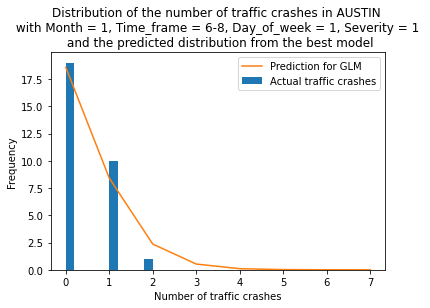

In [49]:
show_results(1, "6-8", 1, 1, "AUSTIN")